In [193]:
from collections import Counter
import datetime
from functools import reduce
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize.casual import TweetTokenizer
#from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import spacy
from spacy.lang.en import English
from spacy import displacy
#!python -m spacy download en_core_web_md #you will need to install this on first load

#nlp = spacy.load('en_core_web_md')

import tensorflow as tf
import tensorflow_hub as hub


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')


[nltk_data] Downloading package wordnet to /home/priyav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/priyav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/priyav/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Use only the words in Google's word2vec so that comparsions can be made with embeddings only performance

In [183]:
with open('data/tweet_doc_word2vec_datasets.pkl', 'rb') as f:
    word_freqs = pickle.load(f)
    
token_arr = word_freqs['train']['tokens']
vocab = word_freqs['vocab']
idx_to_vocab = dict(zip(range(len(vocab)), vocab))

# replace numbers in token array with words
word_arr = [[idx_to_vocab.get(t) for t in tokens] for tokens in token_arr]


In [16]:
# create a dictionary of the words in tweets
dictionary = corpora.Dictionary(word_arr)

# filter out words that appear too often or not often enough
dictionary.filter_extremes(no_below=15, no_above=0.4, keep_n=100000)

# create a bag of words corpus
bow_corpus = [dictionary.doc2bow(text) for text in word_arr]



Text(0.5, 0, 'Number of occurences of word in tweets')

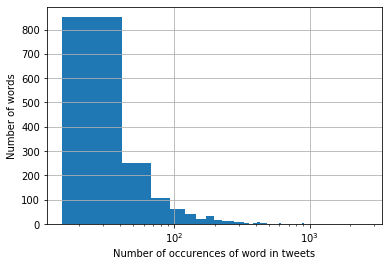

In [17]:
fig, ax = plt.subplots()
pd.Series(list(dictionary.dfs.values())).hist(bins=100, ax=ax)
ax.set_xscale('log')
ax.set_ylabel('Number of words')
ax.set_xlabel('Number of occurences of word in tweets')


Get the parts of speech that are most often used, as well as frequency within these POS.
https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b

['DET' 'ADJ' 'NOUN' 'ADV' 'ADP' 'VERB' 'PRON' 'CONJ' 'NUM' '.']


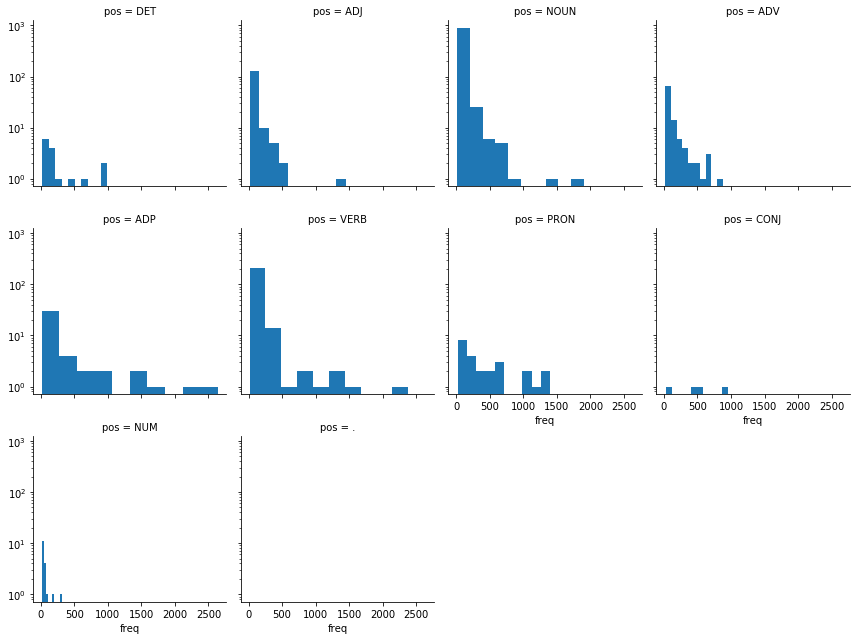

In [24]:
pos_df = pd.DataFrame([[v, k, nltk.pos_tag([k], tagset='universal')[0][1]] for k, v in dictionary.token2id.items()],
                        columns=['id', 'token', 'pos'])

token_freq = pd.DataFrame([[k,v] for k, v in dictionary.dfs.items()],
                          columns=['id', 'freq'])
pos_freq_df = pd.merge(pos_df, token_freq, on='id')

print(pos_freq_df['pos'].unique())

# plot, subset by part of speech, frequency of words
g = sns.FacetGrid(pos_freq_df, col='pos', col_wrap=4)
g.map(plt.hist, "freq", log=True)                  

In [19]:
# look at the adverbs most frequently seen
print(pos_freq_df[pos_freq_df.pos == "JJ"].sort_values("freq", ascending=False))

# look at the nouns most frequently seen
print(pos_freq_df[pos_freq_df.pos=="NN"].sort_values("freq", ascending=False))


# look at the VBG most frequently seen
print(pos_freq_df[pos_freq_df.pos=="NNS"].sort_values("freq", ascending=False))


        id          token pos  freq
104    104          great  JJ  1455
1        1            big  JJ   507
190    190           many  JJ   457
46      46            new  JJ   419
475    475           much  JJ   350
6        6           good  JJ   326
324    324       american  JJ   324
466    466         united  JJ   317
206    206          other  JJ   279
542    542            bad  JJ   236
68      68       military  JJ   229
478    478         strong  JJ   192
535    535     republican  JJ   190
89      89           hard  JJ   186
173    173           last  JJ   179
269    269          total  JJ   173
409    409       national  JJ   167
425    425        illegal  JJ   153
660    660          white  JJ   140
525    525          happy  JJ   125
64      64           high  JJ   113
599    599           true  JJ   113
366    366           real  JJ   111
352    352           such  JJ   108
485    485       southern  JJ   107
539    539      important  JJ   102
441    441           full  J

In [20]:
# create an lda model 
num_topics = 20
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=50, workers=2)

In [21]:
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.033*"retweet" + 0.028*"will" + 0.025*"are" + 0.023*"be" + 0.021*"at"')
(1, '0.041*"great" + 0.033*"america" + 0.029*"again" + 0.025*"make" + 0.020*"many"')
(2, '0.284*"retweet" + 0.077*"trump" + 0.069*"president" + 0.025*"in" + 0.017*"i"')
(3, '0.031*"that" + 0.030*"i" + 0.023*"in" + 0.019*"will" + 0.019*"people"')
(4, '0.026*"with" + 0.025*"our" + 0.019*"for" + 0.018*"in" + 0.018*"will"')
(5, '0.048*"in" + 0.032*"for" + 0.031*"clinton" + 0.029*"hillary" + 0.025*"vote"')
(6, '0.027*"in" + 0.023*"be" + 0.020*"they" + 0.019*"are" + 0.017*"people"')
(7, '0.031*"no" + 0.029*"china" + 0.027*"there" + 0.027*"with" + 0.026*"is"')
(8, '0.033*"than" + 0.031*"in" + 0.027*"more" + 0.023*"our" + 0.022*"has"')
(9, '0.026*"is" + 0.022*"wall" + 0.020*"border" + 0.019*"it" + 0.017*"on"')
(10, '0.033*"it" + 0.020*"be" + 0.020*"are" + 0.018*"do" + 0.017*"we"')
(11, '0.028*"that" + 0.026*"he" + 0.022*"have" + 0.018*"who" + 0.018*"i"')
(12, '0.038*"on" + 0.032*"great" + 0.030*"for" + 0.030*"is" + 0

This suggests that some preopositions, the word retweet, the pronouns, being verbs should be removed

In [43]:
# filter word_array for Part of speech
def filter_word(w):
    # needed to omit some verbs that are also nouns: may, might
    being_verbs = ['to', 'be', 'am', 'is', 'are', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'can', 'could', 'shall', 'should', 'will', 'must']
    valid_pos = ['ADJ', 'NOUN', 'ADV', 'VERB', 'NUM']
    other_disallowed = ['retweet', '....', '.....', 'how', 'who', 'what', 'when', 'where', 'why', "n'\t", "n\'t'"]
    
    if w not in being_verbs:
        if w not in other_disallowed:
            if nltk.pos_tag([w], tagset='universal')[0][1] in valid_pos:
    
                return(True)
    return(False)

filt_pos_arr = [list(filter(filter_word, words)) for words in word_arr]


In [44]:
# create a dictionary of the words in tweets
dictionary_filt = corpora.Dictionary(filt_pos_arr)

# filter out words that appear too often or not often enough
dictionary_filt.filter_extremes(no_below=15, no_above=0.4, keep_n=100000)

# create a bag of words corpus
bow_corpus_filt = [dictionary_filt.doc2bow(text) for text in filt_pos_arr]

# create an lda model 
num_topics = 20
lda_model_filt = gensim.models.LdaMulticore(bow_corpus_filt, num_topics=num_topics, id2word=dictionary_filt, passes=50, workers=2)


In [88]:
topics_filt = lda_model_filt.print_topics(num_words=5)
print("Top 5 words for each topic")
for topic in topics_filt:
    print("Topic {}: {}".format(topic[0], topic[1]))
    
# would be dope to use word cloud
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

Top 5 words for each topic
Topic 0: 0.036*"news" + 0.032*"fake" + 0.027*"media" + 0.018*"never" + 0.018*"ever"
Topic 1: 0.070*"border" + 0.037*"security" + 0.027*"southern" + 0.023*"immigration" + 0.022*"wall"
Topic 2: 0.053*"new" + 0.030*"get" + 0.026*"congratulations" + 0.025*"here" + 0.025*"book"
Topic 3: 0.023*"just" + 0.023*"democrats" + 0.016*"republicans" + 0.016*"political" + 0.015*"there"
Topic 4: 0.029*"great" + 0.027*"tax" + 0.025*"really" + 0.024*"very" + 0.022*"high"
Topic 5: 0.037*"i" + 0.023*"country" + 0.021*"fake" + 0.021*"not" + 0.019*"totally"
Topic 6: 0.024*"not" + 0.021*"world" + 0.019*"trump" + 0.018*"democrats" + 0.017*"there"
Topic 7: 0.043*"i" + 0.026*"very" + 0.025*"just" + 0.025*"up" + 0.019*"korea"
Topic 8: 0.044*"great" + 0.032*"work" + 0.030*"hard" + 0.026*"working" + 0.025*"people"
Topic 9: 0.037*"law" + 0.033*"first" + 0.029*"i" + 0.025*"enforcement" + 0.021*"place"
Topic 10: 0.027*"hillary" + 0.027*"trump" + 0.026*"clinton" + 0.024*"people" + 0.023*"fbi

   dominant_topic_num  num_words dominant_topic
0                  18         17       topic 18
1                  13          3       topic 13
2                  18         18       topic 18
3                  15         16       topic 15
4                   5         20        topic 5


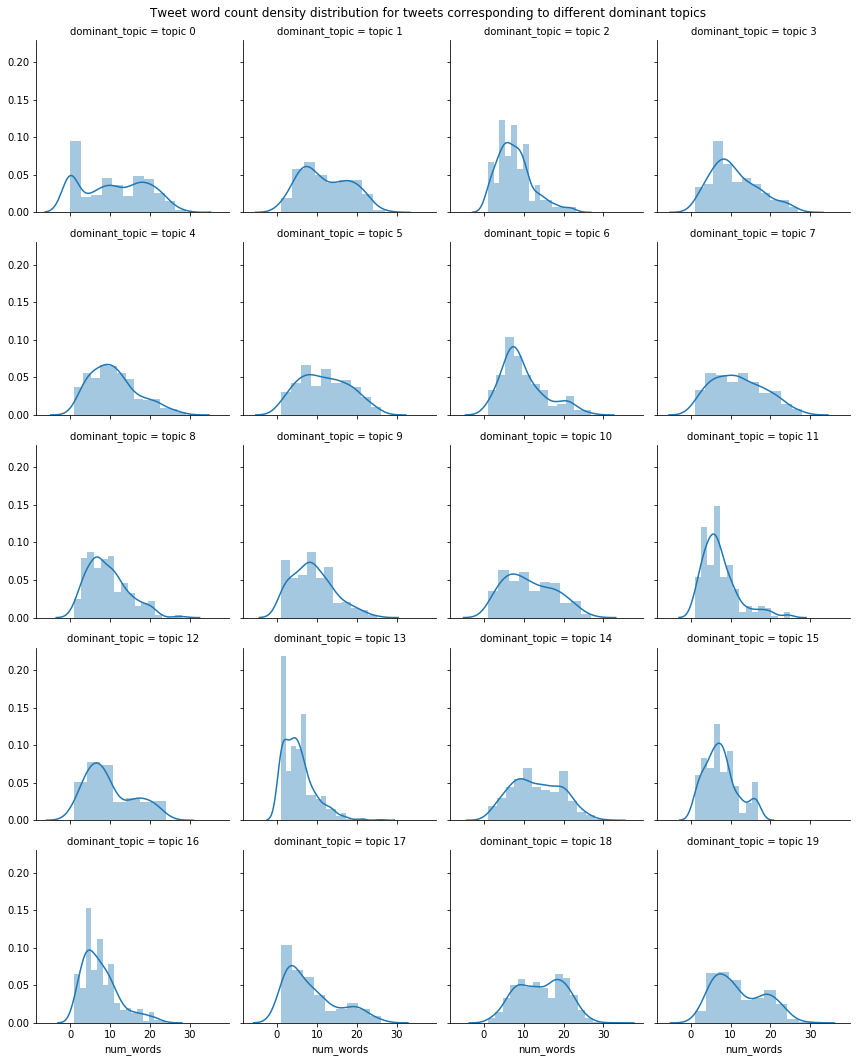

In [85]:

# look at number of words in dominant topic for eahc document
def get_dominant_topic(lda_model, corpus):
    scores = lda_model[corpus]
    dominant_topics = [[x[0] for x in doc_score][np.argmax([x[1] for x in doc_score])] for doc_score in scores]
    return(dominant_topics)

def get_num_words(corpus):
    return([len(c) for c in corpus])



#for i, ax in enumerate(axes.flatten()):    
df_dominant_topic_wc = pd.DataFrame({'dominant_topic_num' :  get_dominant_topic(lda_model_filt,
                                                                               bow_corpus_filt),
                                         'num_words' : get_num_words(bow_corpus_filt)})
df_dominant_topic_wc['dominant_topic'] = ["topic {}".format(x) for x in df_dominant_topic_wc.dominant_topic_num]
print(df_dominant_topic_wc.head())
g = sns.FacetGrid(df_dominant_topic_wc.sort_values('dominant_topic_num'), col='dominant_topic', col_wrap=4)


g.map(sns.distplot, "num_words")
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Tweet word count density distribution for tweets corresponding to different dominant topics') # can also get the figure from plt.gcf()
plt.savefig('plots/topic_model_simple_word_count_distplot.png')   

In [90]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_filt, bow_corpus_filt, dictionary=lda_model_filt.id2word)
vis

/home/priyav/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.059162  0.142816       1        1  11.596108
0     -0.163293  0.045146       2        1  10.719704
14     0.047033  0.112615       3        1   7.515584
19    -0.038023  0.108397       4        1   5.443674
16     0.187049  0.001673       5        1   5.022881
4      0.083256  0.058786       6        1   4.994289
7     -0.059815  0.044938       7        1   4.944566
10    -0.087487  0.035966       8        1   4.645207
8      0.202382  0.085351       9        1   4.444593
1     -0.109989 -0.034263      10        1   4.382678
3     -0.069771  0.145349      11        1   4.156015
5     -0.147443 -0.054337      12        1   4.094535
13     0.183878 -0.210550      13        1   4.081708
6     -0.019158  0.042868      14        1   4.060868
17    -0.058949 -0.073079      15        1   3.661893
2      0.142717  0.035773      16        1   3.547620
12    -0.113987 -0.013249      17        1   3.400689
9      0.105064 -0.065785      18        1   3.385684
11     0.112510 -0.096223      19        1   3.236251
15    -0.136813 -0.312191      20        1   2.665452, topic_info=     Category         Freq          Term        Total  loglift  logprob
73    Default  1419.000000         great  1419.000000  30.0000  30.0000
80    Default   582.000000         thank   582.000000  29.0000  29.0000
172   Default   362.000000        border   362.000000  28.0000  28.0000
231   Default   493.000000       america   493.000000  27.0000  27.0000
145   Default   619.000000          news   619.000000  26.0000  26.0000
74    Default   625.000000           now   625.000000  25.0000  25.0000
30    Default   391.000000           new   391.000000  24.0000  24.0000
140   Default   561.000000          fake   561.000000  23.0000  23.0000
311   Default   326.000000         again   326.000000  22.0000  22.0000
215   Default   263.000000         witch   263.000000  21.0000  21.0000
209   Default   263.000000          hunt   263.000000  20.0000  20.0000
17    Default  1529.000000             i  1529.000000  19.0000  19.0000
143   Default   428.000000          many   428.000000  18.0000  18.0000
1     Default   638.000000       country   638.000000  17.0000  17.0000
253   Default   359.000000         media   359.000000  16.0000  16.0000
64    Default   333.000000          make   333.000000  15.0000  15.0000
14    Default   701.000000          very   701.000000  14.0000  14.0000
35    Default   343.000000          time   343.000000  13.0000  13.0000
126   Default   235.000000    whitehouse   235.000000  12.0000  12.0000
563   Default   435.000000           get   435.000000  11.0000  11.0000
188   Default   426.000000          more   426.000000  10.0000  10.0000
43    Default   595.000000          just   595.000000   9.0000   9.0000
165   Default   288.000000         house   288.000000   8.0000   8.0000
77    Default   209.000000          work   209.000000   7.0000   7.0000
175   Default   167.000000      security   167.000000   6.0000   6.0000
258   Default   433.000000         today   433.000000   5.0000   5.0000
392   Default   377.000000        united   377.000000   4.0000   4.0000
146   Default   884.000000           not   884.000000   3.0000   3.0000
121   Default   815.000000     president   815.000000   2.0000   2.0000
445   Default   131.000000         happy   131.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
878   Topic20    16.345047  transparency    17.276852   3.5694  -4.9678
1376  Topic20    14.428908       changed    15.360712   3.5622  -5.0925
1352  Topic20    13.186870           due    14.118673   3.5565  -5.1825
849   Topic20    11.507143  prescription    12.438948   3.5469  -5.3187
766   Topic20    10.666485      facebook    11.598289   3.5410  -5.3946
1190  Topic20    10.430378      payments    11.362182   3.5392  -5.4170
999   Topic20    10.229777     ta

In [186]:
# get topic probability as a vector for each of the training, test, validation corpus
# Set 0 probability if topic does not appear
#valid_token_arr = [[idx_to_vocab.get(t) for t in tokens] for tokens in word_freqs['validation']['tokens']]
#valid_corpus = [dictionary_filt.doc2bow(text) for text in [list(filter(filter_word, words)) for words in valid_token_arr]]
#valid_corpus_idx = list(zip(word_freqs['valid_idx'].tolist(), valid_corpus))

#test_token_arr = [[idx_to_vocab.get(t) for t in tokens] for tokens in word_freqs['test']['tokens']]
#test_corpus = [dictionary_filt.doc2bow(text) for text in [list(filter(filter_word, words)) for words in test_token_arr]]
#test_corpus_idx = list(zip(word_freqs['test_idx'], test_corpus))

#train_corpus_idx = list(zip(word_freqs['train_idx'].tolist(), bow_corpus_filt))

#all_corpus_idx = train_corpus_idx + valid_corpus_idx + test_corpus_idx
#all_corpus_idx.sort(key=lambda x: x[0])

#all_corpus = [x[1] for x in all_corpus_idx]
tweet_corpus = [dictionary_filt.doc2bow(text) for text in [list(filter(filter_word, words)) for words in word_freqs['tweet_tokens']]]

topic_weights = []
n_topics = 20
for i, row_list in enumerate(lda_model_filt[tweet_corpus]):
    w = np.zeros(20)
    [np.put(w, x[0], x[1]) for x in row_list]
    topic_weights.append(w.tolist())

# Array of topic weights    
topic_weights_df = pd.DataFrame(topic_weights)
arr = topic_weights_df.values
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]


In [203]:
# save topic weights
# first add date information (these tokens originally came from cleaned_tweets)
clean_tweets = pd.read_csv('cleaned_tweets')
clean_tweets.columns
topic_weights_df['Date'] = clean_tweets.apply(lambda x: datetime.date(int(x.year), int(x.month), int(x.day)), axis=1)

# now save to file
topic_weights_df.to_csv('data/topic_model_simple_weights.csv', index=False)


In [162]:
from sklearn.manifold import TSNE
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7955 samples in 0.039s...
[t-SNE] Computed neighbors for 7955 samples in 1.464s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7955
[t-SNE] Computed conditional probabilities for sample 2000 / 7955
[t-SNE] Computed conditional probabilities for sample 3000 / 7955
[t-SNE] Computed conditional probabilities for sample 4000 / 7955
[t-SNE] Computed conditional probabilities for sample 5000 / 7955
[t-SNE] Computed conditional probabilities for sample 6000 / 7955
[t-SNE] Computed conditional probabilities for sample 7000 / 7955
[t-SNE] Computed conditional probabilities for sample 7955 / 7955
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.161613
[t-SNE] KL divergence after 1000 iterations: 1.248176


      TSNE_1     TSNE_2 topic_num
0   9.315612  49.685688   Topic 0
1 -26.608452  31.762362  Topic 18
2  21.773932 -48.592182  Topic 16
3  -8.266021  24.689783  Topic 18
4 -36.704319  32.559830  Topic 18


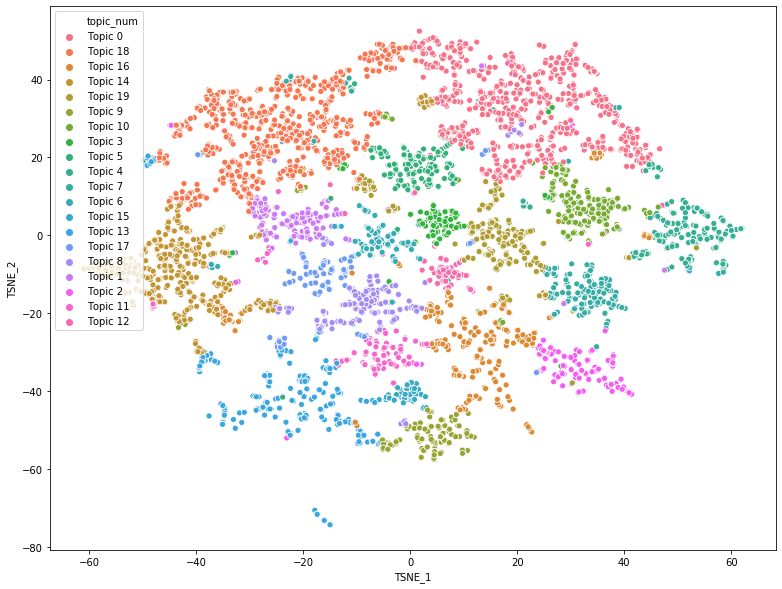

In [177]:
import matplotlib.colors as mcolors

plt.figure(figsize=(13, 10))
tsne_lda_df = pd.DataFrame(tsne_lda,
             columns=["TSNE_1", "TSNE_2"])
tsne_lda_df['topic_num'] = ["Topic {}".format(t) for t in np.argmax(arr, axis=1)]

print(tsne_lda_df.head())
sns.scatterplot(data=tsne_lda_df, x='TSNE_1', y='TSNE_2', hue='topic_num')


Compare existing keywords to topics

In [209]:
cleaned_tweets = pd.read_csv('cleaned_tweets')
keywords = [s.split("_")[1].lower() for s in filter(lambda x: "keyword" in x,  cleaned_tweets.columns)]
keywords

['china',
 'russia',
 'mexico',
 'canada',
 'korea',
 'clinton',
 'democrats',
 'republicans',
 'himself',
 'family',
 'government',
 'media',
 'states',
 'social',
 'obama',
 'fbi',
 'rivals',
 'middleeast',
 'ukraine',
 'economy',
 'disaster']